![](https://media.boingboing.net/wp-content/uploads/2019/01/giphy-3.gif)

# Welcome to my EDA and Modeling kernel !
It's a very cool opportunity to practice and learn from other kagglers about interesting feature encoding techniques and modelling;

I hope you enjoy my work and bring me your feedback. If this kernel is useful for you, please don't forget to upvote the kernel

# Competition description:
Can you find more cat in your dat?

We loved the participation and engagement with the first Cat in the Dat competition.

Because this is such a common task and important skill to master, we've put together a dataset that contains only categorical features, and includes:

binary features
low- and high-cardinality nominal features
low- and high-cardinality ordinal features
(potentially) cyclical features
This follow-up competition offers an even more challenging dataset so that you can continue to build your skills with the common machine learning task of encoding categorical variables. This challenge adds the additional complexity of feature interactions, as well as missing data.

This Playground competition will give you the opportunity to try different encoding schemes for different algorithms to compare how they perform. We encourage you to share what you find with the community.

If you're not sure how to get started, you can check out the Categorical Variables section of Kaggle's Intermediate Machine Learning course.


Have Fun!

# Objective:
I want to do complete exploration to understand the data and after it I will build a Machine Learning Model.

#### Source links:
Encoding Challenge I Notebook--> https://www.kaggle.com/vikassingh1996/handling-categorical-variables-encoding-modeling

Model---> https://www.kaggle.com/peterhurford/why-not-logistic-regression

Visualization-->https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

# Importing Packages and Collecting Data

In [1]:
'''Import basic modules'''
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression

'''import visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

'''Plotly visualization .'''
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

In [2]:
%%time

# Load data
train = pd.read_csv('../input/cat-in-the-dat-ii/train.csv')
test = pd.read_csv('../input/cat-in-the-dat-ii/test.csv')

print(train.shape)
print(test.shape)

(600000, 25)
(400000, 24)
CPU times: user 4.31 s, sys: 527 ms, total: 4.84 s
Wall time: 4.86 s


In [3]:
'''Variable Description'''
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary
bold('**Variable Description of  train Data:**')
description(train)

**Variable Description of  train Data:**

Dataset Shape: (600000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int64,0,600000,0,1,2
1,bin_0,float64,17894,2,0,1,0
2,bin_1,float64,18003,2,0,1,1
3,bin_2,float64,17930,2,0,0,0
4,bin_3,object,18014,2,F,F,F
5,bin_4,object,18047,2,N,Y,N
6,nom_0,object,18252,3,Red,Red,Red
7,nom_1,object,18156,6,Trapezoid,Star,NaN
8,nom_2,object,18035,6,Hamster,Axolotl,Hamster
9,nom_3,object,18121,6,Russia,NaN,Canada


In [4]:
def replace_nan(data):
    for column in data.columns:
        if data[column].isna().sum() > 0:
            data[column] = data[column].fillna(data[column].mode()[0])


replace_nan(train)
replace_nan(test)

# Target Feature
   * Let's see the distribution and if we can identify what is the nature of this feature

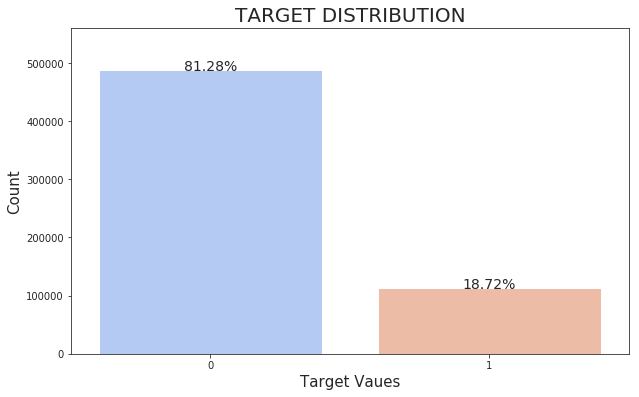

In [5]:
total = len(train)
plt.figure(figsize=(10,6))

g = sns.countplot(x='target', data=train, palette='coolwarm')
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Vaues", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

We can see that data is imbalanced with 81.28% of 0's and 18.72% of 1's.

## Binary Features

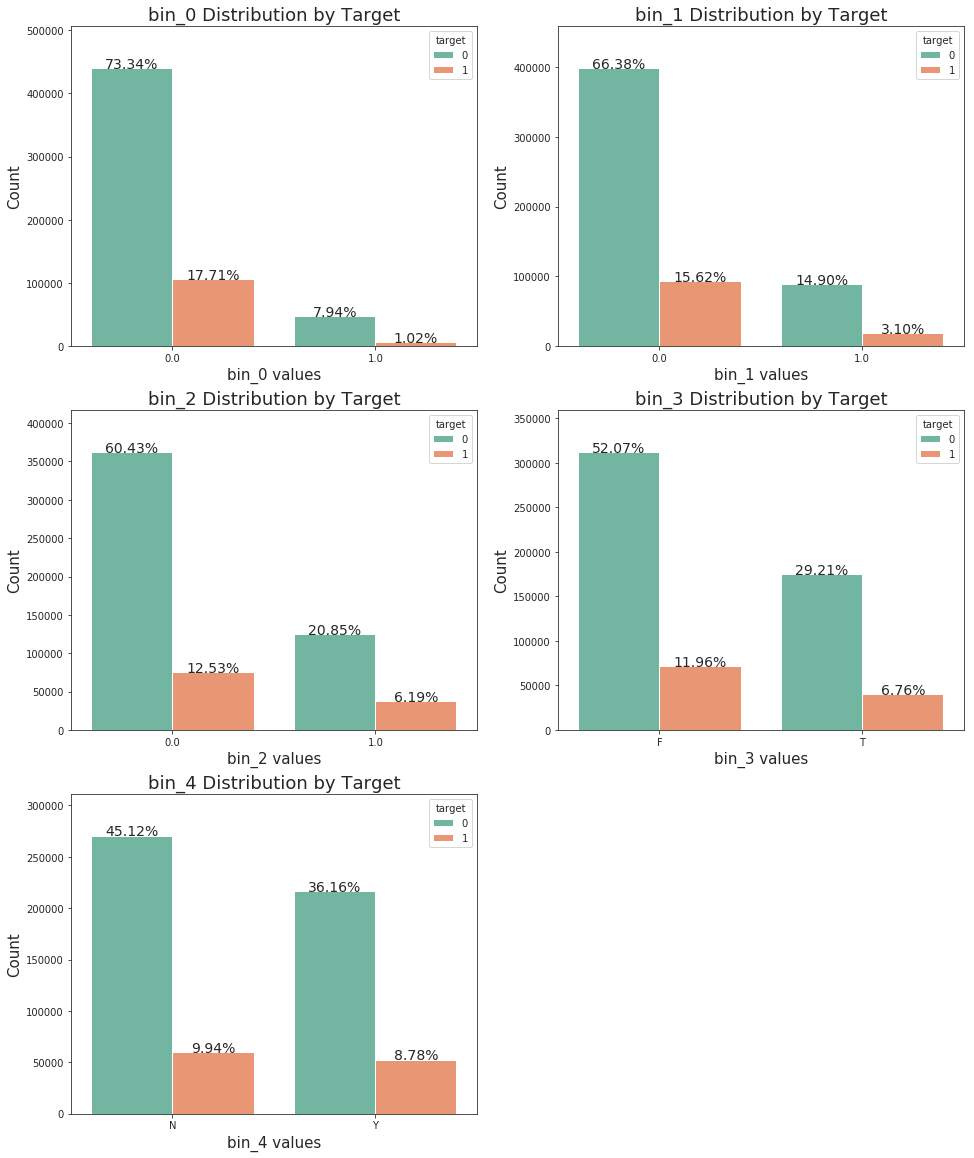

In [6]:
bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 2) # The grid of chart
plt.figure(figsize=(16,20)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(train[bin_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=train, hue='target', palette='Set2') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights
    
plt.show()

In binary variables, it seens that only bin_0 is imbalanced.

# Nominal Features (with more than 2 and less than 15 values)
* Let's see the distribution of the feature and target Ratio for each value in nominal features

In [7]:
nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']


def ploting_cat_fet(df, cols, vis_row=5, vis_col=2):
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35)) # size of figure

    # loop to get column and the count of plots
    for n, col in enumerate(train[cols]): 
        tmp = pd.crosstab(train[col], train['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=train, order=list(tmp[col].values) , palette='Set1') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

        # twinX - to build a second yaxis
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()

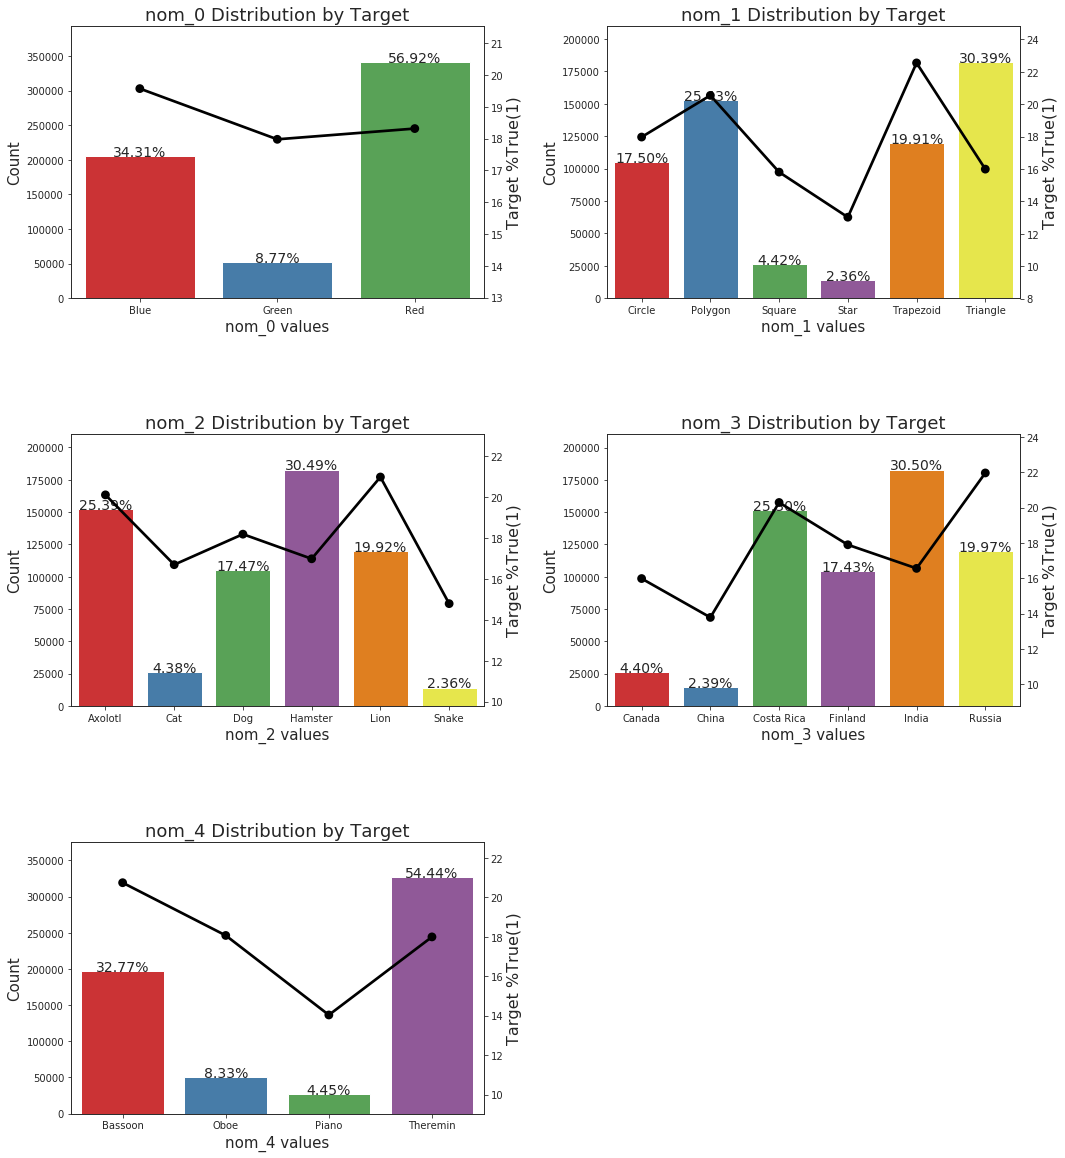

In [8]:
ploting_cat_fet(train, nom_cols, vis_row=5, vis_col=2)

# Ordinal Features (with more than 2 and less than 15 values)

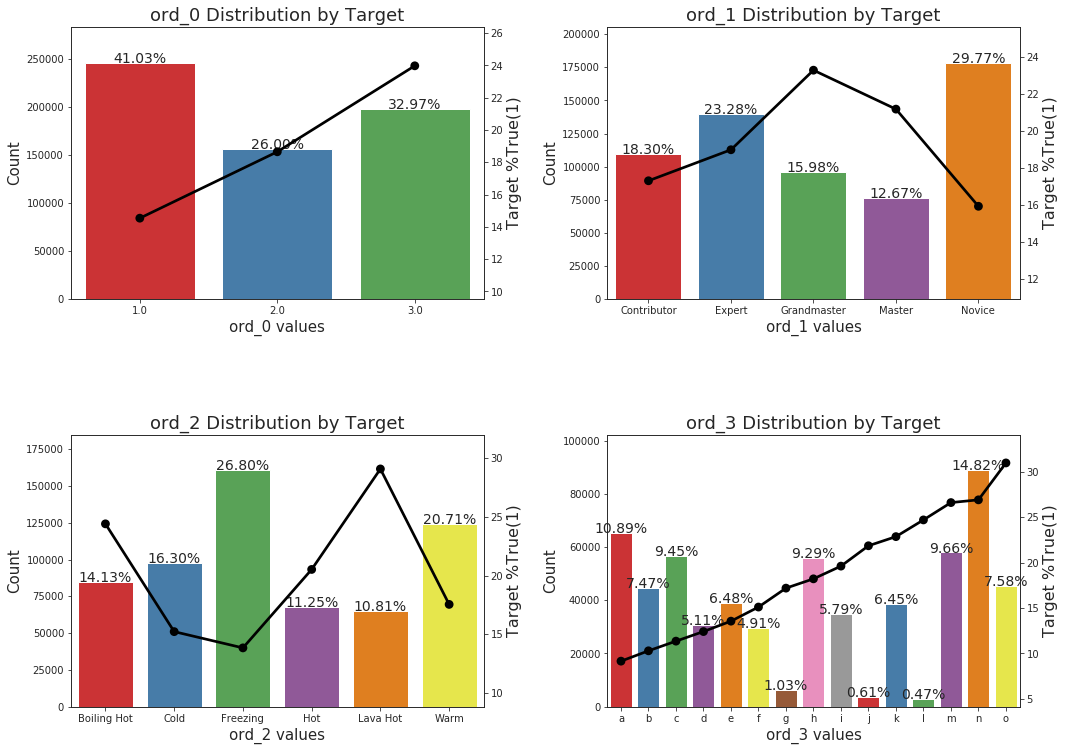

In [9]:
ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3']

#Ploting
ploting_cat_fet(train, ord_cols, vis_row=5, vis_col=2)

## Ord_4 and ord_5 (More than 15 Values)

In [10]:
train['ord_5_ot'] = 'Others'
train.loc[train['ord_5'].isin(train['ord_5'].value_counts()[:25].sort_index().index), 'ord_5_ot'] = train['ord_5']

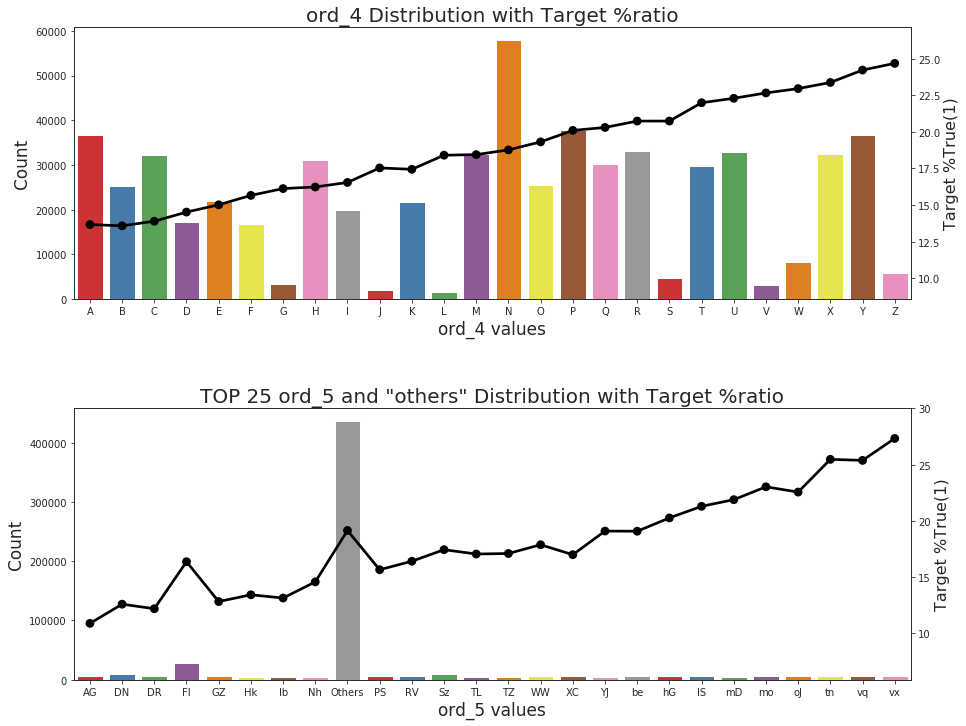

In [11]:
tmp = pd.crosstab(train['ord_4'], train['target'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)
plt.figure(figsize=(15,12))

plt.subplot(211)
ax = sns.countplot(x='ord_4', data=train, order=list(tmp['ord_4'].values) , palette='Set1') 
ax.set_ylabel('Count', fontsize=17) # y axis label
ax.set_title('ord_4 Distribution with Target %ratio', fontsize=20) # title label
ax.set_xlabel('ord_4 values', fontsize=17) # x axis label
# twinX - to build a second yaxis
gt = ax.twinx()
gt = sns.pointplot(x='ord_4', y='Yes', data=tmp,
                   order=list(tmp['ord_4'].values),
                   color='black', legend=False)
gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
gt.set_ylabel("Target %True(1)", fontsize=16)

tmp = pd.crosstab(train['ord_5_ot'], train['target'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

plt.subplot(212)
ax1 = sns.countplot(x='ord_5_ot', data=train,
                   order=list(train['ord_5_ot'].value_counts().sort_index().index) ,
                   palette='Set1') 
ax1.set_ylabel('Count', fontsize=17) # y axis label
ax1.set_title('TOP 25 ord_5 and "others" Distribution with Target %ratio', fontsize=20) # title label
ax1.set_xlabel('ord_5 values', fontsize=17) # x axis label
# twinX - to build a second yaxis
gt = ax1.twinx()
gt = sns.pointplot(x='ord_5_ot', y='Yes', data=tmp,
                   order=list(train['ord_5_ot'].value_counts().sort_index().index),
                   color='black', legend=False)
gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
gt.set_ylabel("Target %True(1)", fontsize=16)

plt.subplots_adjust(hspace = 0.4, wspace=.3)

plt.show()

# Date Features

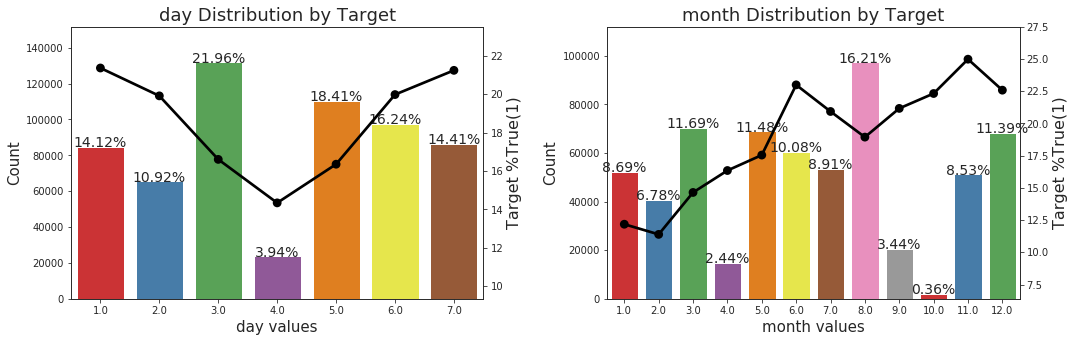

In [12]:
date_cols = ['day', 'month']

# Calling the plot function with date columns
ploting_cat_fet(train, date_cols, vis_row=5, vis_col=2)

# Feature Engineering

In [13]:
%%time

'''Subset'''
target = train['target']
train_id = train['id']
test_id = test['id']
train.drop(['target', 'id','ord_5_ot'], axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

print(train.shape)
print(test.shape)
print(target.shape)

(600000, 23)
(400000, 23)
(600000,)
CPU times: user 255 ms, sys: 121 ms, total: 376 ms
Wall time: 295 ms


In [14]:
%%time

'''One Hot Encode'''
traintest = pd.concat([train, test])
dummies = pd.get_dummies(traintest, columns=traintest.columns, drop_first=True, sparse=True)
train_ohe = dummies.iloc[:train.shape[0], :]
test_ohe = dummies.iloc[train.shape[0]:, :]

print(train_ohe.shape)
print(test_ohe.shape)

(600000, 5678)
(400000, 5678)
CPU times: user 3min 55s, sys: 1.16 s, total: 3min 56s
Wall time: 3min 56s


In [15]:
%%time
'''Covert dataframe to spare matrix'''
train_ohe = train_ohe.sparse.to_coo().tocsr()
test_ohe = test_ohe.sparse.to_coo().tocsr()
type(train_ohe)

CPU times: user 2.48 s, sys: 286 ms, total: 2.77 s
Wall time: 2.77 s


scipy.sparse.csr.csr_matrix

In [16]:
%%time

# Model
def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None, label='model'):
    kf = KFold(n_splits=5)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    i = 1
    for dev_index, val_index in fold_splits:
        print('Started ' + label + ' fold ' + str(i) + '/5')
        dev_X, val_X = train[dev_index], train[val_index]
        dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score))
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / 5.0
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores}
    return results


def runLR(train_X, train_y, test_X, test_y, test_X2, params):
    print('Train LR')
    model = LogisticRegression(**params)
    model.fit(train_X, train_y)
    print('Predict 1/2')
    pred_test_y = model.predict_proba(test_X)[:, 1]
    print('Predict 2/2')
    pred_test_y2 = model.predict_proba(test_X2)[:, 1]
    return pred_test_y, pred_test_y2


lr_params = {'solver': 'liblinear', 'C':  0.1, 'max_iter': 1000}
results = run_cv_model(train_ohe, test_ohe, target, runLR, lr_params, auc, 'lr')

Started lr fold 1/5
Train LR
Predict 1/2
Predict 2/2
lr cv score 1: 0.7839993301799459
Started lr fold 2/5
Train LR
Predict 1/2
Predict 2/2
lr cv score 2: 0.7849151629285103
Started lr fold 3/5
Train LR
Predict 1/2
Predict 2/2
lr cv score 3: 0.7849061477915906
Started lr fold 4/5
Train LR
Predict 1/2
Predict 2/2
lr cv score 4: 0.7851666503613537
Started lr fold 5/5
Train LR
Predict 1/2
Predict 2/2
lr cv score 5: 0.7838562445151402
lr cv scores : [0.7839993301799459, 0.7849151629285103, 0.7849061477915906, 0.7851666503613537, 0.7838562445151402]
lr cv mean score : 0.784568707155308
lr cv std score : 0.0005335216991207499
CPU times: user 1min 42s, sys: 592 ms, total: 1min 43s
Wall time: 1min 27s


In [17]:
%%time
submission = pd.DataFrame({'id': test_id, 'target': results['test']})
submission.to_csv('submission.csv', index=False)

CPU times: user 4.61 s, sys: 504 ms, total: 5.12 s
Wall time: 8.08 s


In [18]:
import pandas as pd
sample_submission = pd.read_csv("../input/cat-in-the-dat-ii/sample_submission.csv")
test = pd.read_csv("../input/cat-in-the-dat-ii/test.csv")
train = pd.read_csv("../input/cat-in-the-dat-ii/train.csv")

# Give me your feedback and if you find my kernel helpful please UPVOTE will be appreciated.